<h1 align="center">CS51 Final Project:</h1>
<h2 align="center">Restricted Boltzmann Machines and Deep Belief Networks</h2>
<h3 align="center">By Angela Fan, Andre Nguyen, Vincent Nguyen, and George Zeng</h3>

##Imports

In [1]:
%matplotlib inline

from __future__ import absolute_import, print_function, unicode_literals, division
from IPython.display import Image
from sklearn.datasets import fetch_mldata, fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import random as rand
import copy
from pylab import rcParams

##RBM Implementation

In [2]:
class RBM(object):
    """
    Implementation of Restricted Boltzmann Machine for binary prediction
    
    Inputs:
    Data
    Number of hidden and visible states
    Learning rate, default set to 0.1
    Number of Epochs to train for
    Option for which unit to use, either "binary" or "continuous"
    
    Outputs:
    Weight matrix
    Epoch number and error
    """

    def __init__(self, data, num_visible, num_hidden, num_epochs, learning_rate=0.1, unit="binary"):
        
        self.data = data
        self.num_data = data.shape[0]
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.unit = unit

        # weight matrix first row and first column represent the bias
        self.weights = np.random.rand(self.num_visible, self.num_hidden) 
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)
        
    def _relu(self, x):
        """
        Rectifier continuous Activation Function
        """
        return np.maximum(0,x)
        
    def _sigmoid(self, x):
        """
        Sigmoid Binary Activation function
        """
        return 1.0/(1.0+np.exp(-x))
    
    def _gen_prob(self,a,b):   
        if self.unit == "binary":
            return self._sigmoid(np.dot(a,b))
        elif self.unit == "continuous":
            return self._relu(np.dot(a,b))
        else:
            raise "Unknown Unit"
    
    def _gen_assoc(self,a):
        probs = (self._gen_prob(a,self.weights))
        #print(probs)
        return np.dot(a.T,probs)
    
    def _sample_v_given_h(self, h):  # h does not contain bias
        probs = self._gen_prob(self.weights, np.insert(h,0,1))        
        if self.unit == "binary":
            sample = probs > np.random.rand(self.num_visible + 1)
        elif self.unit == "continuous":
            sample = probs + np.random.randn(self.num_visible + 1)
        return sample[1:]
    
    def _sample_h_given_v(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1, axis = 1).T)
        if self.unit == "binary":
            sample = probs > np.random.rand(self.num_hidden + 1, self.num_data)
        elif self.unit == "continuous":
            sample = probs + np.random.randn(probs.shape[0], probs.shape[1])
        return sample[1:].T
    
    def _sample_h_given_v_nontrain(self, v):  # v does not contain bias
        probs = self._gen_prob(self.weights.T, np.insert(v,0,1).T)      
        if self.unit == "binary":
            sample = probs > np.random.rand(self.num_hidden + 1)
        elif self.unit == "continuous":
            sample = probs + np.random.randn(self.num_hidden + 1)
        return sample[1:]
    
    def CDk(self):
        """
        Implementation of CD-k iterative training algorithm
        """
        max_epochs = self.num_epochs + 1
        
        # array to keep track of errors for plotting
        error_array = []
        
        # insert the bias layer into the data
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        # iterate for each epoch
        for epoch in xrange(0, max_epochs):
            
            # CD-k positive phase
            up_probs = self._gen_prob(self.data,self.weights)
            up_associations = self._gen_assoc(self.data)
            if self.unit == "binary":
                up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)
            elif self.unit == "continuous":
                up_states = up_probs + np.random.randn(up_probs.shape[0], up_probs.shape[1])
            
            # CD-k negative phase
            down_probs = self._gen_prob(up_states,self.weights.T)
            down_probs[:,0] = 1 
            down_associations = self._gen_assoc(down_probs)
            
            # Update weights iteratively based on positive and negative phases
            self.weights += self.learning_rate * \
                ((up_associations - down_associations)/self.num_data)
                                
            # Calculate error
            error = np.sum((self.data - down_probs) ** 2)
            
            error_array.append(error)

            # Print information about the last epoch
            if epoch == self.num_epochs:
                print("Layers: ", self.num_hidden, "Rate: ", self.learning_rate, "Epoch: ", epoch, ", Error: ", error)
                return down_probs, error_array
            
    def train(self, up_probs, error_array, epoch):
        """
        Trains the RBM, calling CDk or PCDk depending on user input
        """
        up_associations = self._gen_assoc(self.data)
        if self.unit == "binary":
            up_states = up_probs > np.random.rand(self.num_data, self.num_hidden + 1)
        elif self.unit == "continuous":
            up_states = up_probs + np.random.randn(up_probs.shape[0], up_probs.shape[1])

        # CD-k negative phase
        down_probs = self._gen_prob(up_states,self.weights.T)
        down_probs[:,0] = 1 
        down_associations = self._gen_assoc(down_probs)

        # Update weights iteratively based on positive and negative phases
        self.weights += self.learning_rate * \
            ((up_associations - down_associations)/self.num_data)

        # Calculate error
        error = np.sum((self.data - down_probs) ** 2)

        error_array.append(error)
        
        return down_probs, error
    
    def PCDk(self):
        """
        Implementation of Persistent CD-k iterative training algorithm
        
        aims to sample almost directly from the model distribution to better approximate
        the likelihood gradient when the mixing is low
        
        Based on this work: http://www.cs.toronto.edu/~tijmen/pcd/pcd.pdf
        """
        max_epochs = self.num_epochs + 1
        
        # array to keep track of errors for plotting
        error_array = []
        
        down_probs = []
        
        # insert the bias layer into the data
        self.data = np.insert(self.data, 0, 1, axis=1)
        
        # iterate for each epoch
        for epoch in xrange(0, max_epochs):
            
            # CD-k positive phase
            if epoch == 0:
                up_probs = self._gen_prob(self.data,self.weights)
            else:
                up_probs = self._gen_prob(down_probs,self.weights)
                
            down_probs, error = self.train(up_probs, error_array, epoch)
            
            # Print information about the last epoch
            if epoch == self.num_epochs:
                print("Layers: ", self.num_hidden, "Rate: ", self.learning_rate, "Epoch: ", epoch, ", Error: ", error)
                return down_probs, error_array


##Toy Datatset of Movie Ratings

In [2]:
alice = {"Interstellar":1, "Whiplash":1, "Selma":0, "Lego Movie":0, "Birdman":0}
eric = {"Interstellar":0, "Whiplash":0, "Selma":0, "Lego Movie":1, "Birdman":0}
nancy = {"Interstellar":1, "Whiplash":1, "Selma":1, "Lego Movie":0, "Birdman":1}
sarah = {"Interstellar":0, "Whiplash":1, "Selma":0, "Lego Movie":0, "Birdman":1}
mike = {"Interstellar":1, "Whiplash":1, "Selma":1, "Lego Movie":1, "Birdman":1}
bob = {"Interstellar":0, "Whiplash":1, "Selma":1, "Lego Movie":0, "Birdman":1}

data = {"alice":alice, "eric":eric, "nancy":nancy}#, "sarah":sarah} "mike":mike, "bob":bob}

data = pd.DataFrame.from_dict(data)
data.head()

,alice,eric,nancy
Birdman,0,0,1
Interstellar,1,0,1
Lego Movie,0,1,0
Selma,0,0,1
Whiplash,1,0,1


In [3]:
movie_data_array = np.array(data)
print(movie_data_array)
print(movie_data_array.shape)

[[0 0 1]
 [1 0 1]
 [0 1 0]
 [0 0 1]
 [1 0 1]]
(5, 3)


####Run RBM Toy Movie Dataset-Binary

In [14]:
visible_units = movie_data_array.shape[1]
epochs = 100
hidden_units = 1000
learning_rate = 0.1

r = RBM(movie_data_array, visible_units, hidden_units, epochs, learning_rate, "binary")
sample, error = r.CDk()
print(r.weights)
print(sample[:,1:])

Layers:  1000 Rate:  0.1 Epoch:  100 , Error:  0.324451903327
[[ 0.07159995 -0.16022143 -0.18693898 ..., -0.07215804 -0.04424126
  -0.19677318]
 [-0.32168214 -0.14046451  0.26625593 ..., -0.1900093   0.16291792
   0.33309176]
 [-0.25645439  0.05565567  0.16614305 ..., -0.26616485 -0.12906386
  -0.47701999]
 [-0.27322064  0.27114345  0.04170731 ...,  0.14858261 -0.34979067
   0.4406472 ]]
[[  3.80930870e-03   1.77191937e-08   9.99999997e-01]
 [  9.99145618e-01   4.44428823e-10   9.99590868e-01]
 [  5.76430028e-07   9.99999997e-01   2.21783504e-05]
 [  5.69593271e-01   1.16595929e-08   9.99999810e-01]
 [  9.99999504e-01   1.94343693e-10   9.99996384e-01]]


##Fetch MNIST Dataset

In [6]:
DATA_PATH = '~/data'
mnist = fetch_mldata('MNIST original', data_home=DATA_PATH)
print(mnist.data.shape)

(70000, 784)


#### Example Image

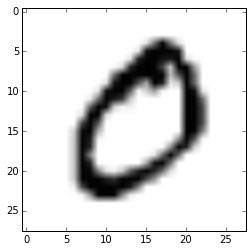

In [7]:
mnist_bin_data_array = mnist.data
plt.imshow(mnist_bin_data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

#### Standard basic RBMs take binary inputs only, so we'll convert the image to a binary matrix

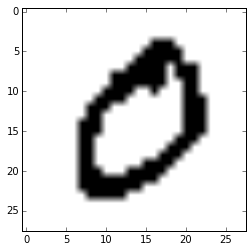

In [8]:
for img in mnist_bin_data_array:
    # set arbitrary, reasonable cutoff
    img[img < 100] = 0
    img[img > 0] = 1

# sample image after converting to binary matrix
plt.imshow(mnist_bin_data_array[0].reshape(28, 28), cmap = 'Greys')
plt.show()

#### Run RBM on MNIST dataset- Binary

In [60]:
visible_units = mnist_bin_data_array.shape[1]
epochs = 10
hidden_units = 100
learning_rate = 0.1

r = RBM(mnist_bin_data_array, visible_units, hidden_units, epochs, learning_rate, "binary")
sample, error = r.CDk()
print(r.weights)

Layers:  100 Rate:  0.1 Epoch:  10 , Error:  5875823.91069
[[ 0.11134249  0.00294052 -0.01300772 ...,  0.00106157 -0.00470908
  -0.006305  ]
 [-0.05032108 -0.49213499  0.0398472  ..., -0.37152426  0.13562119
  -0.42069932]
 [-0.05041215  0.12357339 -0.2079445  ..., -0.5299373   0.09260831
   0.12360469]
 ..., 
 [-0.05101434  0.15507701  0.33747953 ...,  0.31762844  0.24827861
  -0.53617701]
 [-0.05024257 -0.56361156  0.29681684 ..., -0.39320578 -0.28608538
  -0.01105544]
 [-0.05029308 -0.26031837  0.11849238 ...,  0.19891894 -0.53985023
  -0.33148175]]


#### Run RBM on MNIST dataset- Continuous

In [61]:
mnist_con_data_array = mnist.data

visible_units = mnist_con_data_array.shape[1]
epochs = 10
hidden_units = 100
learning_rate = 10 ** (-10)

r = RBM(mnist_con_data_array, visible_units, hidden_units, epochs, learning_rate, "continuous")
sample, error = r.CDk()
print(r.weights)

Layers:  100 Rate:  1e-10 Epoch:  10 , Error:  4.07587340469e+12
[[  0.00000000e+00  -1.37705397e-04  -1.41398135e-04 ...,  -1.45785416e-04
   -1.48483514e-04  -1.43966592e-04]
 [  0.00000000e+00   2.01407457e-02   5.59102050e-01 ...,   5.40224391e-02
    3.99801488e-01  -2.38881035e-01]
 [  0.00000000e+00  -3.73549405e-02  -7.84686853e-02 ...,   2.86247265e-01
    6.44716332e-01   2.64400385e-01]
 ..., 
 [  0.00000000e+00  -1.42927113e-01   5.85230782e-01 ...,  -1.23902654e-01
    4.72986286e-01   6.03004354e-02]
 [  0.00000000e+00   3.52275992e-01   5.38799316e-01 ...,  -1.31911872e-01
    3.86203976e-01   5.45647289e-01]
 [  0.00000000e+00  -1.09535928e-01   4.28498344e-01 ...,   2.56604405e-01
    3.55557317e-01  -2.10463197e-01]]


## Parameter Optimization using Cross Validation 

In [6]:
visible_units = mnist_bin_data_array.shape[1]
max_epochs = 100
max_hidden_layers = 11
max_learning_rate = 10

# cross validation
for hidden_layers in xrange(1, max_hidden_layers):
    for learning_rate in xrange(1, max_learning_rate):
        r = RBM(mnist_bin_data_array, visible_units, 100*hidden_layers, max_epochs, learning_rate/float(10))
        r.CDk()

Layers:  100 Rate:  0.1 Epoch:  100 , Error:  2924093.40296
Layers:  100 Rate:  0.2 Epoch:  100 , Error:  2590810.49885
Layers:  100 Rate:  0.3 Epoch:  100 , Error:  2419529.13044
Layers:  100 Rate:  0.4 Epoch:  100 , Error:  2953467.43609
Layers:  100 Rate:  0.5 Epoch:  100 , Error:  3080931.4865
Layers:  100 Rate:  0.6 Epoch:  100 , Error:  4649189.5418
Layers:  100 Rate:  0.7 Epoch:  100 , Error:  13714638.9772
Layers:  100 Rate:  0.8 Epoch:  100 , Error:  7172705.9948
Layers:  100 Rate:  0.9 Epoch:  100 , Error:  2575479.49496
Layers:  200 Rate:  0.1 Epoch:  100 , Error:  2379539.26787
Layers:  200 Rate:  0.2 Epoch:  100 , Error:  2171885.90979
Layers:  200 Rate:  0.3 Epoch:  100 , Error:  2084536.22896
Layers:  200 Rate:  0.4 Epoch:  100 , Error:  2846840.70569
Layers:  200 Rate:  0.5 Epoch:  100 , Error:  3097520.46994
Layers:  200 Rate:  0.6 Epoch:  100 , Error:  4288084.20697
Layers:  200 Rate:  0.7 Epoch:  100 , Error:  13712224.226
Layers:  200 Rate:  0.8 Epoch:  100 , Error:

In [8]:
cv = pd.read_csv("crossval.csv")
cv.head()

,Hidden Units,Learning Rate,Error
0,100,0.1,2924093.403
1,100,0.2,2590810.499
2,100,0.3,2419529.130
3,100,0.4,2953467.436
4,100,0.5,3080931.487


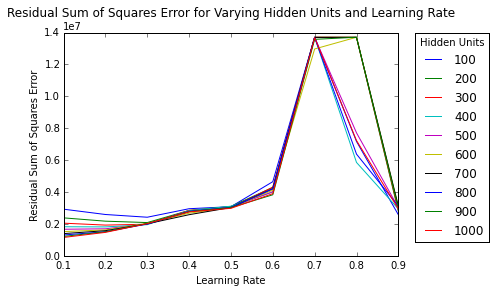

In [9]:
for key, grp in cv.groupby(['Hidden Units']):
    plt.plot(grp['Learning Rate'], grp['Error'], label=key)

plt.legend(title='Hidden Units',bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Residual Sum of Squares Error for Varying Hidden Units and Learning Rate', y=1.05)
plt.xlabel('Learning Rate')
plt.xlim([0.1, 0.9])
plt.ylabel('Residual Sum of Squares Error') 
plt.show()

## Visualizing our RBM Output on MNIST 

In [91]:
def net_and_plot(data, num_hidden, epochs, dataset, \
                 learning_rate=.3, unit="binary", \
                 persistent=False, net="RBM", \
                 images= [11, 12002, 15005, 19005, 28005, 32005, 39007, 43004, 49010, 58030]):
    """
    Trains and plots RBM output on MNIST dataset
    
    Inputs:
    data 
    number of hidden states
    number of epochs
    RBM learning rate, default set to 0.3
    
    Outputs:
    Trained RBM weight matrix
    Example of RBM prediction on an example digit from the MNIST dataset
    Graph of error as a function of epoch
    """
    
    # Set up RBM
    num_visible = data.shape[1]
    
    if net == "RBM":
        r = RBM(data, num_visible, num_hidden, epochs, learning_rate, unit)
        # Train RBM
        if persistent == True:
            sample = r.PCDk()
        else:
            sample = r.CDk()
    else: 
        r = DBN(data, [num_visible,50,20], epochs, learning_rate, "binary", verbose=False)
        r._build()
    
    if dataset == "MNIST":
        f = plt.subplots(10,5, figsize=(15,15))
        iter1 = 10
        color = "Greys"
        shape = [28, 28]
    elif dataset == "Faces":
        f = plt.subplots(6,5, figsize=(15,15))
        iter1 = 6
        color = plt.cm.gray
        shape = [62, 47]
    else:
        print("Sorry, not a known dataset")

    # Set up subplots and titles for the columns
    f[1][0,0].set_title("Original Image", fontsize=18).set_position([.5, 1.35])
    f[1][0,1].set_title(net + " Probabilities", fontsize=18).set_position([.5, 1.35])
    f[1][0,2].set_title(net + " Sample 1", fontsize=18).set_position([.5, 1.35])
    f[1][0,3].set_title(net + " Sample 2", fontsize=18).set_position([.5, 1.35])
    f[1][0,4].set_title(net + " Sample 3", fontsize=18).set_position([.5, 1.35])    
    
    # Iterate over digits/faces
    for i in xrange(0, iter1):
        
        if net == "DBN":
            h = r._dbn_sample_h_given_v(data[images[i]])
            v = r._dbn_sample_v_given_h(h)
        
        # Iterate over columns
        for j in xrange(0, 5):
            
            # First column is original image
            if j == 0:
                f[1][i, j].imshow(data[images[i]].reshape(shape[0], shape[1]), cmap=color)
            # Second column is RBM prediction
            elif j == 1:
                if net == "DBN":
                    f[1][i, j].imshow(v.reshape(shape[0],shape[1]), cmap=color)
                else:
                    f[1][i, j].imshow(sample[0][images[i]][1:].reshape(shape[0], shape[1]), cmap=color)            
            # Third to Fifth columns are RBM samples
            else:
                if net == "DBN":
                    s = v.reshape(shape[0],shape[1])
                else:
                    s = sample[0][images[i]][1:].reshape(shape[0],shape[1])
                
                if unit == "binary":
                    img = s > np.random.rand(s.shape[0], s.shape[1]) 
                elif unit == "continuous":
                    img = s + np.random.randn(s.shape[0], s.shape[1])
                f[1][i, j].imshow(img, cmap="Greys")

            # Get rid of useless axes
            f[1][i, j].get_xaxis().set_visible(False)
            f[1][i, j].get_yaxis().set_visible(False)

    plt.suptitle(net + " Trained on " + dataset + " Dataset", fontsize=25)
    plt.show()
    
    # Plot error linegraph
    if net == "RBM":
        rcParams['figure.figsize'] = 5, 5
        err = sample[1]
        plt.plot(err)
        plt.yscale('log')
        plt.ylabel("Error")
        plt.xlabel("Epoch")
        plt.title("Error over Epochs")
        plt.show()
    
        return r.weights

####Binary Linear Units

Layers:  100 Rate:  0.1 Epoch:  1000 , Error:  1901897.56491


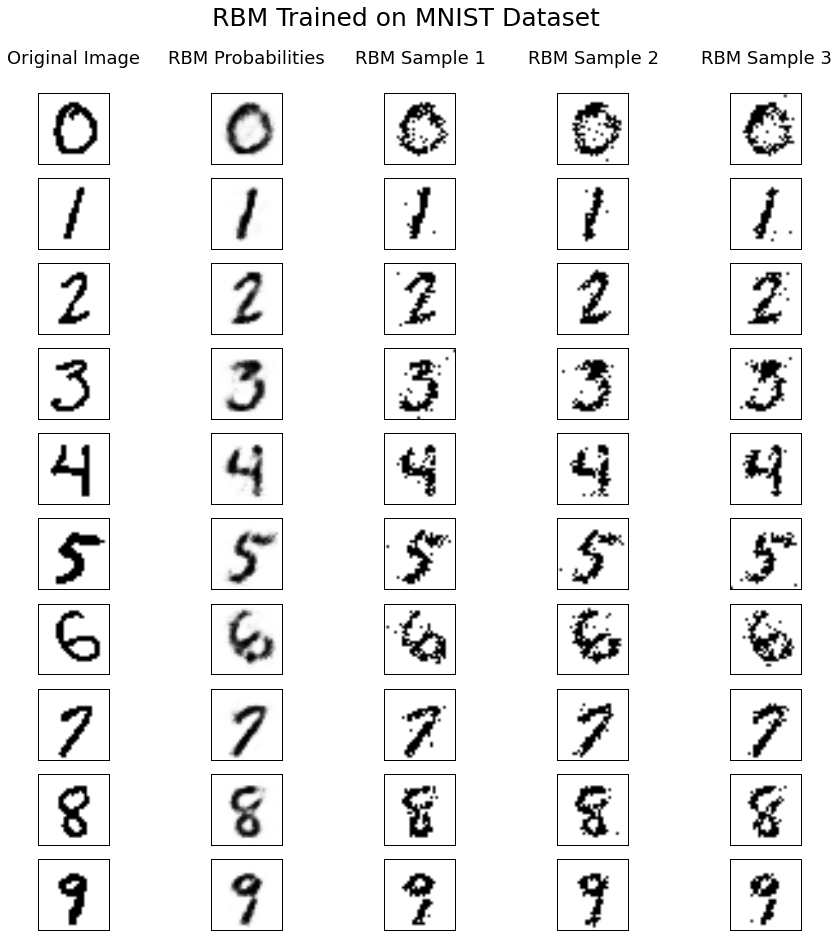

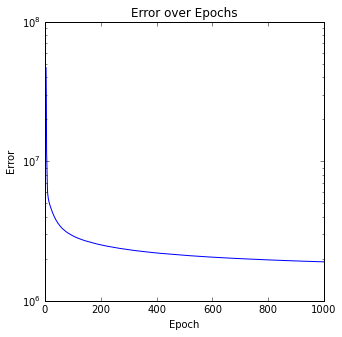

array([[ 2.38350397,  0.94751129,  2.7534052 , ...,  2.10463543,
         1.00502888,  1.06332949],
       [-0.36326772, -0.5379705 , -0.51286061, ...,  0.09885153,
        -0.68404078, -0.21198356],
       [-0.33678388,  0.10095599, -0.19471354, ...,  0.10565443,
         0.00968083, -0.08641277],
       ..., 
       [-0.27277255, -0.2367128 ,  0.11438062, ...,  0.15390482,
        -0.48999884,  0.17297348],
       [-0.3567985 ,  0.05652801, -0.08698196, ..., -0.0057992 ,
        -0.61062198, -0.30776863],
       [-0.35160092,  0.29796841, -0.21187222, ...,  0.21245542,
        -0.01880568, -0.39883002]])

In [59]:
net_and_plot(mnist_bin_data_array, num_hidden=100, epochs=1000, learning_rate=0.1, unit="binary", dataset="MNIST")

####Continuous Retifier Linear Units

Layers:  100 Rate:  1e-10 Epoch:  1000 , Error:  169743520798.0


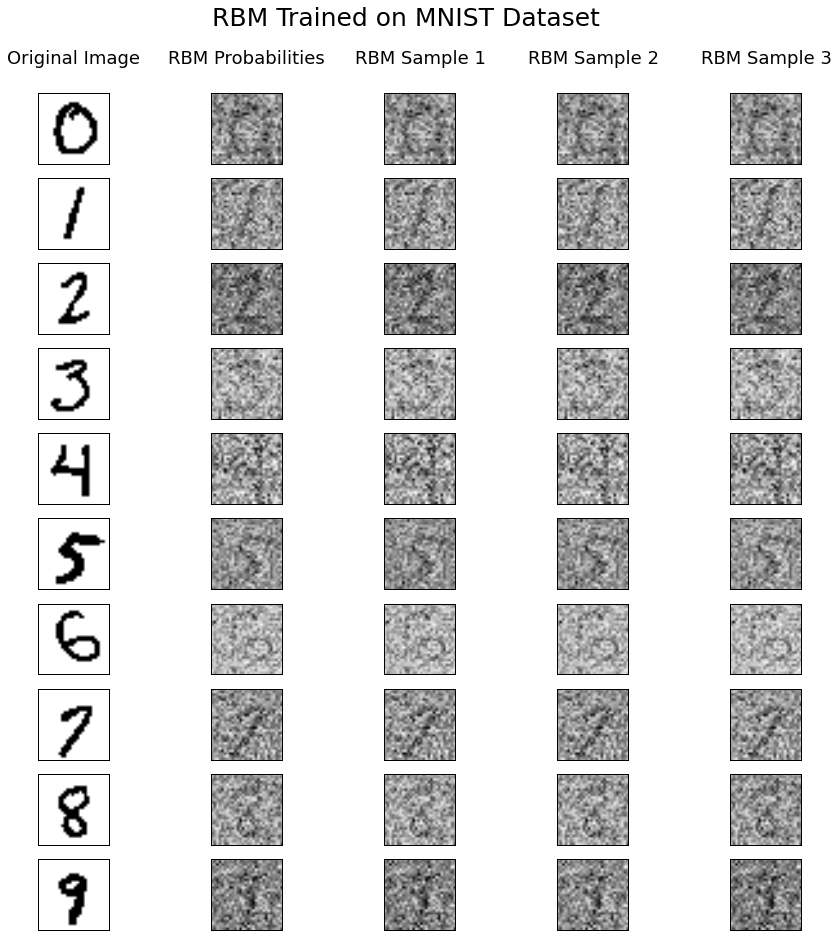

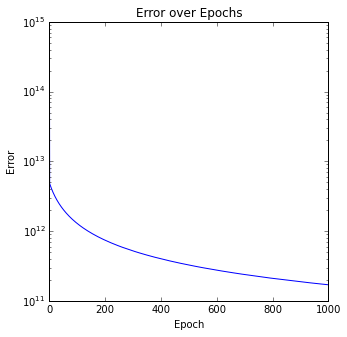

array([[ 0.        , -0.00079161, -0.00077129, ..., -0.00079544,
        -0.00077513, -0.00077995],
       [ 0.        , -0.07053577,  0.43586276, ..., -0.36917095,
         0.50176234,  0.34489912],
       [ 0.        ,  0.00127988,  0.38070129, ...,  0.11929174,
        -0.24729263,  0.29161126],
       ..., 
       [ 0.        ,  0.44499665,  0.23498613, ...,  0.30210623,
        -0.30700533, -0.30809989],
       [ 0.        , -0.21717247, -0.20035716, ...,  0.44987013,
         0.04781243, -0.12337666],
       [ 0.        ,  0.47766708, -0.26427348, ..., -0.18533338,
         0.13441406, -0.03438451]])

In [58]:
net_and_plot(mnist_con_data_array, num_hidden=100, epochs=1000, learning_rate=(10**(-10)), unit="continuous", dataset="MNIST")

#### Binary Linear Units with Persistent CDk

Layers:  100 Rate:  0.1 Epoch:  10 , Error:  9613704.46462


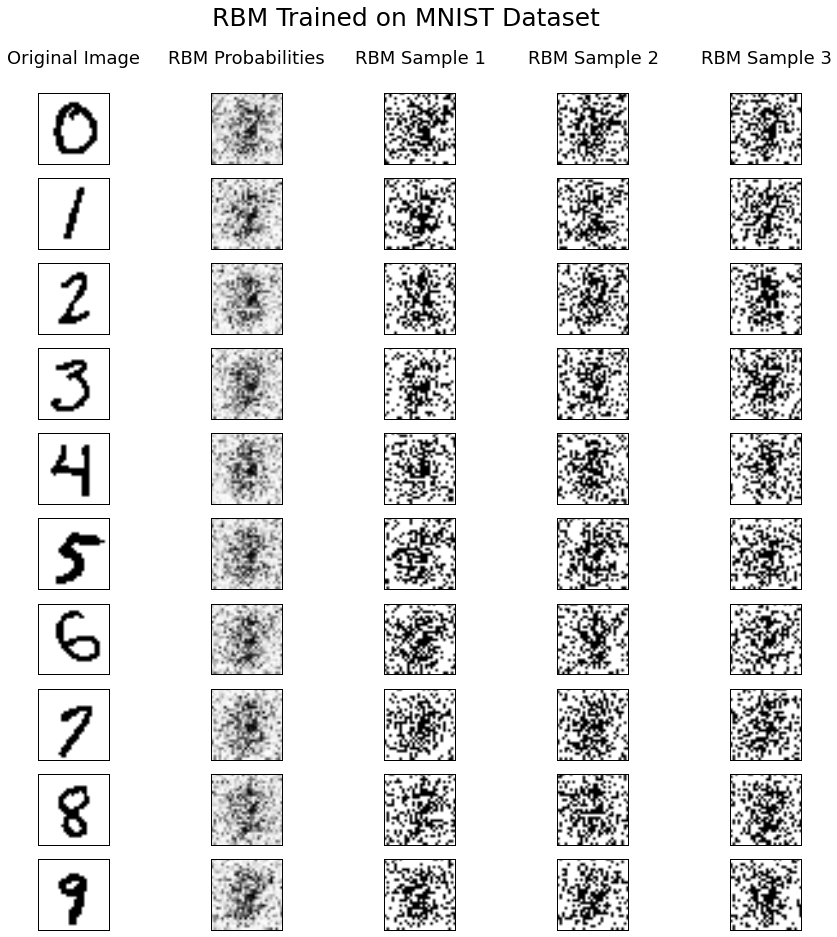

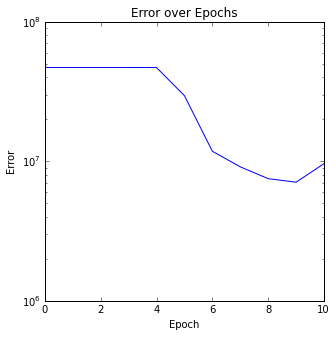

array([[  9.90491611e-02,  -5.41271585e-02,  -8.23896174e-03, ...,
         -1.03875437e-02,  -1.63729317e-02,  -3.48112345e-02],
       [ -5.05426532e-02,  -4.02599117e-01,  -1.09021911e-01, ...,
         -1.51717814e-01,   1.65288466e-01,   5.63175648e-04],
       [ -5.01070141e-02,  -9.41516598e-02,   3.23419339e-05, ...,
          3.24745778e-01,  -5.12335421e-01,   7.33034782e-03],
       ..., 
       [ -5.12728131e-02,  -2.52346177e-01,  -3.82454794e-01, ...,
          4.74573991e-02,   1.80300586e-01,  -1.83450691e-01],
       [ -5.02524047e-02,  -1.19785389e-01,   2.24455970e-01, ...,
          3.62335015e-02,  -4.41302901e-01,   1.70376857e-01],
       [ -5.04514072e-02,  -1.84107408e-01,   2.52288598e-01, ...,
          4.23840001e-01,   3.07252825e-01,  -1.62242861e-01]])

In [10]:
net_and_plot(mnist_bin_data_array, dataset="MNIST", num_hidden=100, epochs=10, learning_rate=0.1, unit="binary", persistent=True)

##Fetch FACES Dataset

In [113]:
lfw_people = fetch_lfw_people(min_faces_per_person=70)
print(lfw_people.data.shape)
print(lfw_people.images.shape)

(1288, 2914)
(1288, 62, 47)


####Example Image

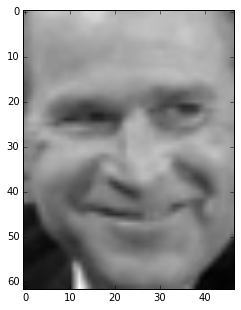

In [104]:
faces_con_data_array = lfw_people.data
person = lfw_people.target
names = lfw_people.target_names

plt.imshow(faces_con_data_array[909].reshape(62,47), cmap=plt.cm.gray)
#plt.title(names[person][0])
plt.show()

#### Run RBM on FACES dataset-Continuous

In [52]:
visible_units = faces_con_data_array.shape[1]
epochs = 10
hidden_units = 100
learning_rate = .1#10 ** (-10)

r = RBM(faces_con_data_array, visible_units, hidden_units, epochs, learning_rate, "continuous")
sample, error = r.CDk()
print(r.weights)

Layers:  100 Rate:  0.1 Epoch:  10 , Error:  6.36983781163e+14
[[    0.          -337.75260007  -342.52164281 ...,  -338.04843447
   -339.25245314  -340.00525837]
 [    0.         -1728.0176108  -1754.06410017 ..., -1727.53349416
  -1737.17203503 -1737.03444481]
 [    0.         -1829.03760157 -1851.59409015 ..., -1829.31889559
  -1834.58912044 -1836.64202755]
 ..., 
 [    0.         -1951.63869107 -1984.47722633 ..., -1959.32486474
  -1967.14346022 -1970.96322889]
 [    0.         -1889.62234277 -1910.20359915 ..., -1889.23563091
  -1896.16002265 -1896.42372733]
 [    0.         -1834.53420529 -1858.50006973 ..., -1834.30255863
  -1841.71638082 -1837.7907893 ]]


##Visualization of RBM FACES Output

####Binary Linear Units

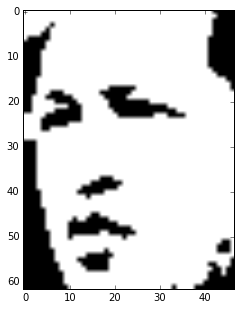

In [101]:
faces_bin_data_array = lfw_people.data

for img in faces_bin_data_array:
    # set arbitrary, reasonable cutoff
    img[img < 100] = 0
    img[img > 0] = 1

# sample image after converting to binary matrix
plt.imshow(faces_bin_data_array[0].reshape(62, 47), cmap = plt.cm.gray)
plt.show()

Layers:  100 Rate:  0.1 Epoch:  100 , Error:  638380.245247


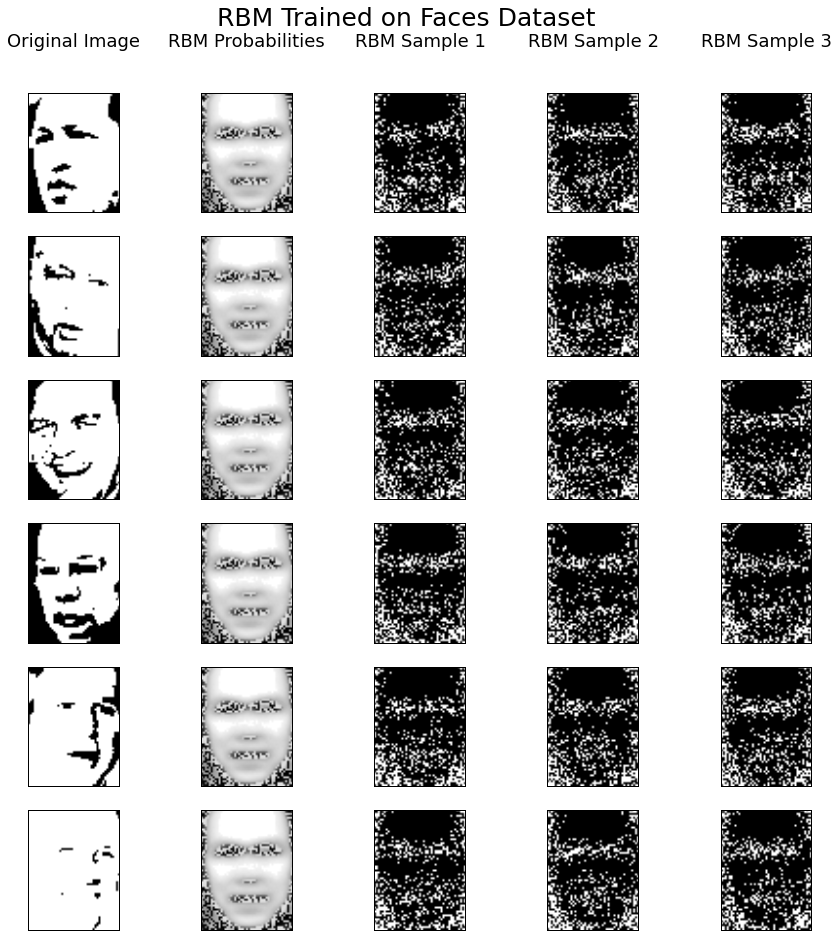

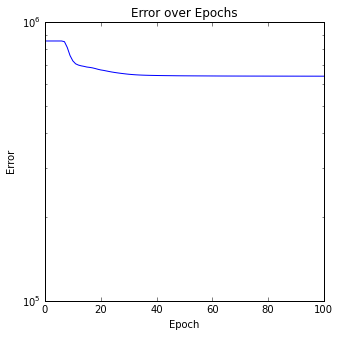

array([[  2.11094867e-04,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [ -3.03553758e-02,  -2.35297241e-01,   3.35254879e-01, ...,
         -1.17839011e-01,  -2.92733658e-01,   2.06345885e-01],
       [ -2.91515488e-02,   2.49469334e-01,   4.05983551e-01, ...,
         -8.34514575e-02,  -2.79111035e-01,   1.06589311e-01],
       ..., 
       [ -2.27043738e-02,   1.40072428e-01,  -4.02367713e-01, ...,
         -2.40128642e-01,   4.85179669e-01,   4.31190851e-01],
       [ -2.46047734e-02,  -3.32409782e-01,   3.20157189e-01, ...,
          3.30097105e-01,   2.76096209e-01,  -3.61725138e-02],
       [ -2.65514622e-02,   4.09398616e-01,   2.06223123e-02, ...,
         -1.89390749e-01,  -2.94981252e-01,   2.79976310e-01]])

In [33]:
net_and_plot(faces_bin_data_array, dataset="Faces", num_hidden=100, epochs=100, learning_rate=0.1, images = [0, 9, 301, 500, 600, 801, 902,2,3,4])

####Continuous Linear Retifier Units

####Eigenface Decomposition

In [164]:
# transformation to eigenfaces for easier prediction
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import RandomizedPCA

n_samples, h, w = lfw_people.images.shape

X = lfw_people.data
n_features = X.shape[1]

y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

# Do PCA 
n_components = 150
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenfaces = np.array([eigenfaces[r].ravel() for r in xrange(len(eigenfaces))])
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

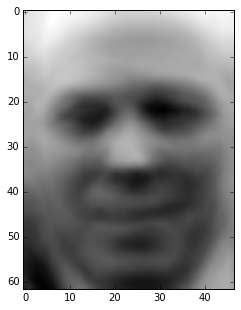

In [152]:
plt.imshow(eigenfaces[3], cmap = plt.cm.gray)
plt.show()

Layers:  10000 Rate:  1e-10 Epoch:  10 , Error:  952015745.538


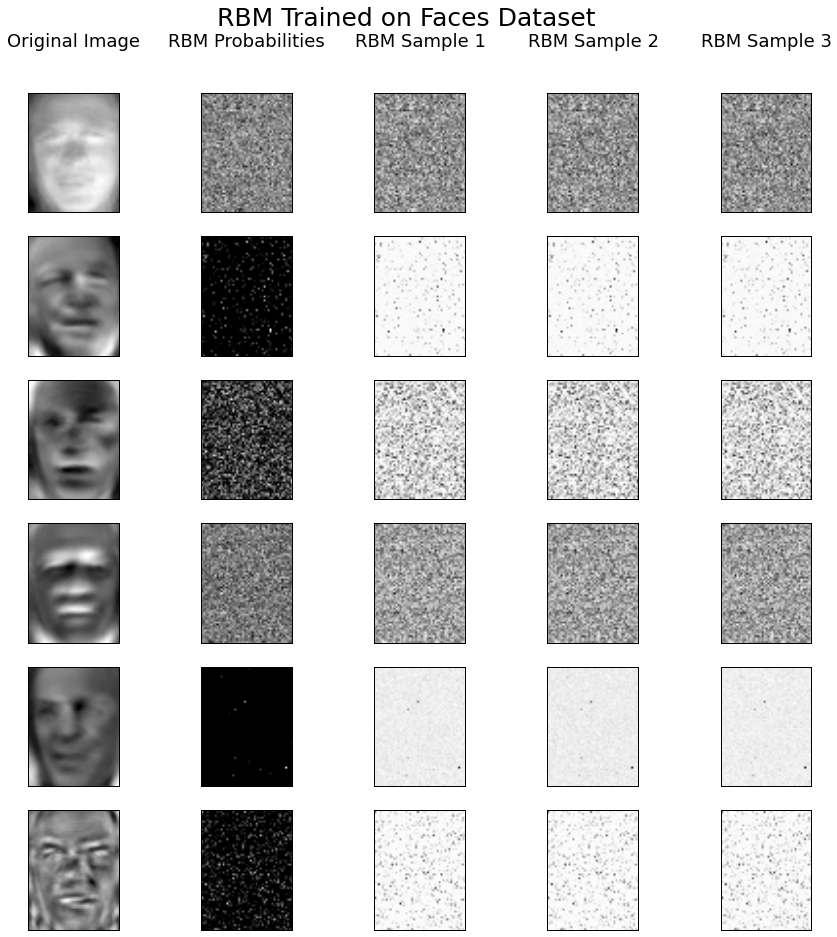

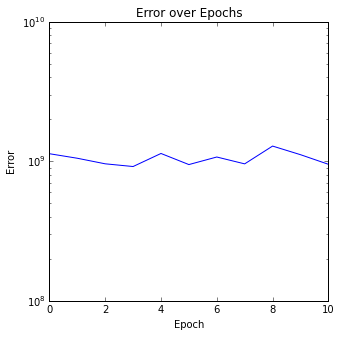

array([[  0.00000000e+00,  -4.80494686e-05,  -4.81622120e-05, ...,
         -4.90185249e-05,  -4.70521821e-05,  -4.79973211e-05],
       [  0.00000000e+00,   8.78584822e-02,   2.97895125e-01, ...,
          5.29066526e-01,   5.46780032e-01,   8.85855141e-01],
       [  0.00000000e+00,   9.06613408e-01,   1.75633454e-01, ...,
          6.56260140e-03,   7.97547693e-01,   5.37313902e-01],
       ..., 
       [  0.00000000e+00,   2.35043328e-01,   3.56726476e-01, ...,
          1.25014668e-02,   3.14215942e-02,   4.85934203e-01],
       [  0.00000000e+00,   6.19584306e-01,   2.48245605e-01, ...,
          1.32411072e-01,   8.38518561e-01,   7.22037539e-01],
       [  0.00000000e+00,   3.59864735e-01,   8.59572642e-01, ...,
          5.01160878e-01,   5.99201501e-01,   2.11001107e-01]])

In [171]:
net_and_plot(new, dataset="Faces", num_hidden=10000, epochs=10, unit="continuous",learning_rate=10**(-10), images = [0, 9, 10, 5, 6, 81, 92,2,3,4])

##Deep Belief Network

### Stacking RBMs to perform deep learning

In [56]:
class DBN(object):
    """
    Implementation of Deep Belief Network, made by stacking RBMs
    
    Inputs:
    data
    layer_nodes, an array that describes desired network architecture
    
    Example:
    [3, 4, 5, 3] will form a DBN with:
    - 3 unit visible layer
    - 4 unit hidden layer 
    - 5 unit hidden layer
    - 3 unit hidden layer
    
    number of epochs to train from
    learning rate, default set to 0.1
    unit, either "binary" or "continuous", default set to binary
    
    Outputs:
    set of weights
    """

    def __init__(self, data, layer_nodes, num_epochs, learning_rate=0.1, unit="binary", verbose="true"):
        
        self.data = data
        self.num_data = data.shape[0]
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.layer_nodes = layer_nodes
        self.num_layers = len(self.layer_nodes)
        self.unit = unit
        self.verbose = verbose
        
        # List of stacked RBMs
        self.RBM_layer = range(0,len(self.layer_nodes)-1)  
        
        # List of messages 
        self.RBM_layer_messages = range(0,len(self.layer_nodes))  
        self.RBM_layer_messages[0] = self.data
        
    def _build(self):
        """
        Builds the DBN
        """
                
        for i in xrange(0,len(self.layer_nodes)-1):
            
            # create each RBM layer by creating separate RBM objects
            self.RBM_layer[i] = RBM(self.RBM_layer_messages[i], \
                                    self.layer_nodes[i], \
                                    self.layer_nodes[i+1], \
                                    self.num_epochs, \
                                    self.learning_rate, \
                                    self.unit)
            
            # train each RBM layer using RBM implementation of CDk
            down_probs, err = self.RBM_layer[i].CDk()  
            
            # create messages to pass between the layers
            self.RBM_layer_messages[i+1] = self.RBM_layer[i]._sample_h_given_v(self.RBM_layer_messages[i])
            
            # error
            if self.verbose=='true':
                print(i)
                print(self.RBM_layer_messages[i])
                print(down_probs[:,1:])
            error = np.sum((self.RBM_layer_messages[i] - down_probs[:,1:]) ** 2)
                #print("DBN Layer: ", i, ", DBN Error: ", error)
            
        return
    
    def _dbn_sample_v_given_h(self, h):  
        # h does not contain bias
        
        temp = h
        for i in xrange(len(self.layer_nodes)-2,-1,-1):
            temp = self.RBM_layer[i]._sample_v_given_h(temp)
        return temp
    
    def _dbn_sample_h_given_v(self, v):  
        # v does not contain bias
        
        temp = v
        for i in xrange(0,len(self.layer_nodes)-1):
            temp = self.RBM_layer[i]._sample_h_given_v_nontrain(temp)
        return temp


#### Run DBN on MNIST Dataset-Binary

In [57]:
visible_units = mnist_bin_data_array.shape[1]
num_epochs = 100
learning_rate = .1

dbn_learner = DBN(mnist_bin_data_array, [visible_units,50,20], num_epochs, learning_rate, "binary")
dbn_learner._build()

Layers:  50 Rate:  0.1 Epoch:  100 , Error:  3496020.50833
0
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[[ 0.00492819  0.00549051  0.00774508 ...,  0.00297041  0.0032872
   0.00553306]
 [ 0.01910588  0.00488     0.03104681 ...,  0.00802658  0.00743313
   0.00636401]
 [ 0.01294218  0.00367623  0.0029864  ...,  0.00184888  0.00831927
   0.00335396]
 ..., 
 [ 0.03605589  0.02277818  0.00988552 ...,  0.0132194   0.01932307
   0.00934589]
 [ 0.05645437  0.00696527  0.0030777  ...,  0.00526559  0.00729224
   0.00586908]
 [ 0.06353777  0.00862632  0.01534719 ...,  0.00709842  0.01016411
   0.00545075]]
Layers:  20 Rate:  0.1 Epoch:  100 , Error:  540263.380236
1
[[False  True False ..., False  True  True]
 [False  True False ..., False  True  True]
 [False  True False ..., False  True  True]
 ..., 
 [ True  True False ...,  True False False]
 [ True  True False ...,  True False  True]
 [ True  True False ...,

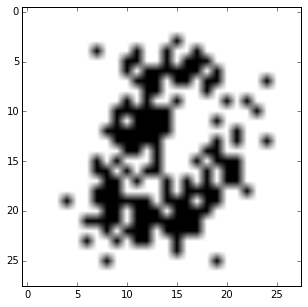

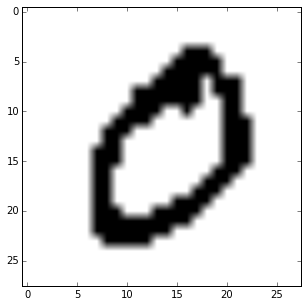

In [58]:
img = 0

h = dbn_learner._dbn_sample_h_given_v(mnist_bin_data_array[img])
v = dbn_learner._dbn_sample_v_given_h(h)

plt.imshow(v.reshape(28,28), cmap = 'Greys')
plt.show()

plt.imshow(mnist_bin_data_array[img].reshape(28,28), cmap = 'Greys')
plt.show()

## Visualizing on DBN MNIST Output

####Binary Linear Units

Layers:  50 Rate:  0.1 Epoch:  100 , Error:  3494419.74444
Layers:  20 Rate:  0.1 Epoch:  100 , Error:  562408.91279


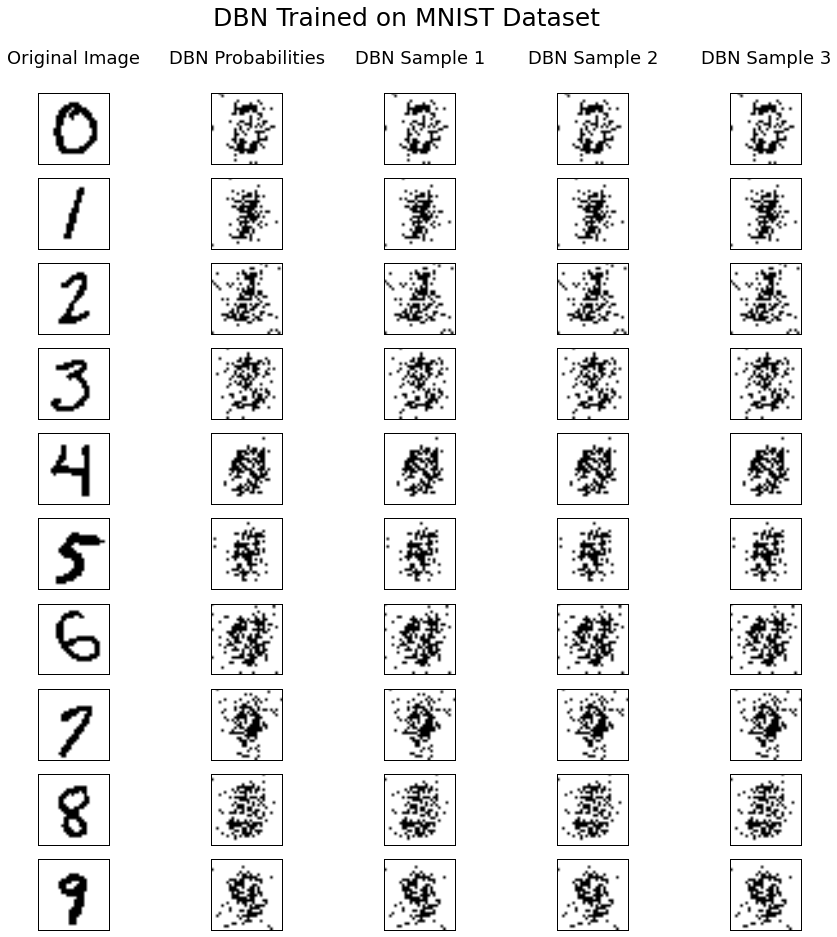

In [59]:
net_and_plot(mnist_bin_data_array, num_hidden=100, epochs=100, dataset="MNIST", learning_rate=.1, unit="binary", persistent=False, net="DBN")

####Continuous Linear Units

Layers:  50 Rate:  1e-10 Epoch:  3 , Error:  47051392.9858
Layers:  20 Rate:  1e-10 Epoch:  3 , Error:  0.1038676537


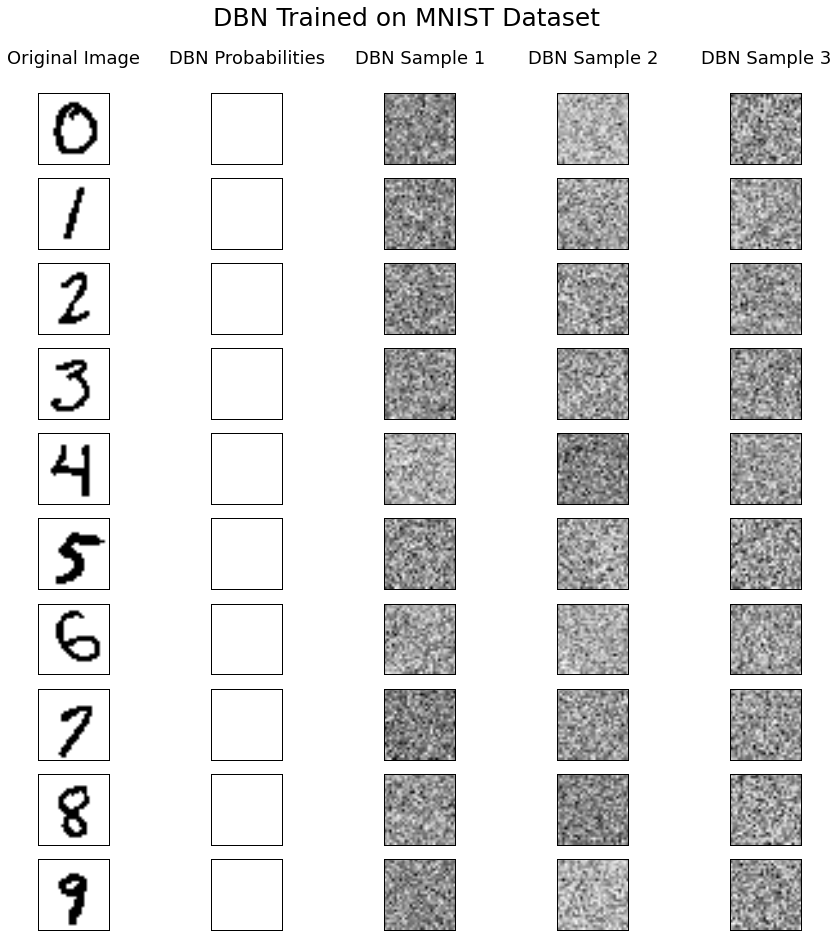

In [67]:
mnist_con_data_array = mnist.data
net_and_plot(mnist_con_data_array, num_hidden=100, epochs=3, dataset="MNIST", learning_rate=10**(-10), unit="continuous", persistent=False, net="DBN")

##Visualizing on DBN FACES Output

####Binary Linear Units on Binarized Faces

Layers:  50 Rate:  0.1 Epoch:  10 , Error:  685184.403066
Layers:  20 Rate:  0.1 Epoch:  10 , Error:  0.00195422906043


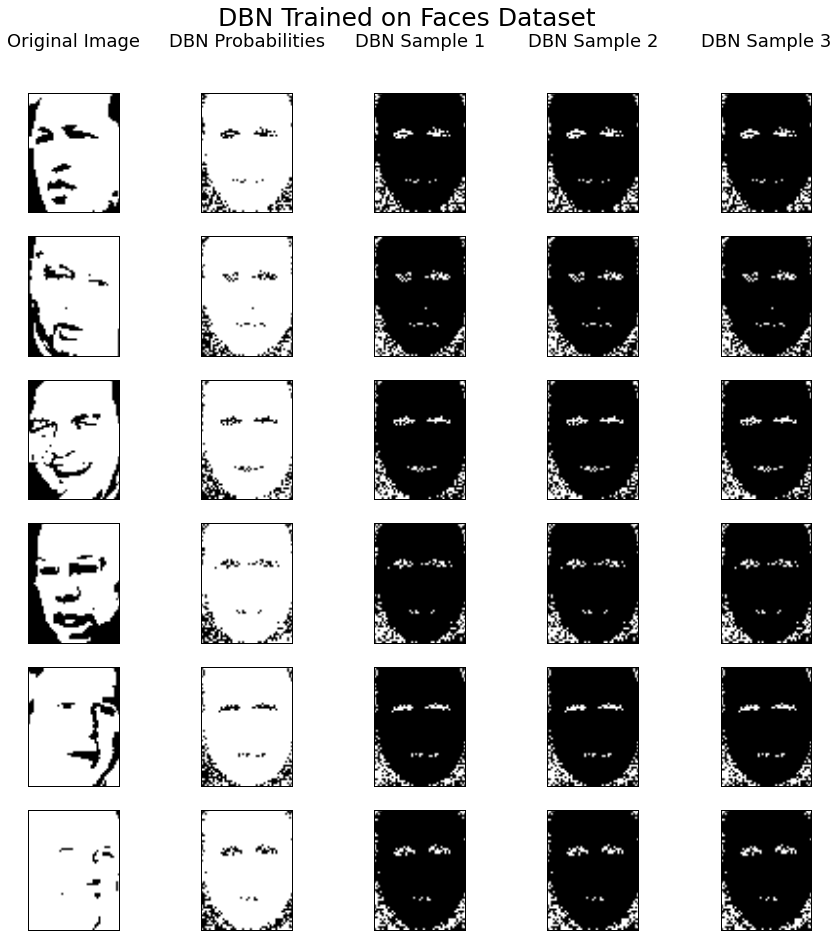

In [92]:
net_and_plot(faces_bin_data_array, dataset="Faces", num_hidden=100, epochs=10, learning_rate=0.1, images = [0, 9, 301, 500, 600, 801, 902,2,3,4], net="DBN")

####Continuous Linear Units on Eigenface reduction

In [ ]:
net_and_plot(new, dataset="Faces", num_hidden=100, epochs=100, learning_rate=0.1, images = [0, 9, 301, 500, 600, 801, 902,2,3,4], net="DBN")